# Custom predictors for recursive multi-step forecasting

It may be interesting to include additional features of the time series besides the lags. For example, the moving average of the n last values ​​can be used to capture the trend of the series.

The `ForecasterAutoregCustom` class is very similar to the `ForecasterAutoreg` class described in the previous section, but the user defines the function used to create the predictors.

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Data

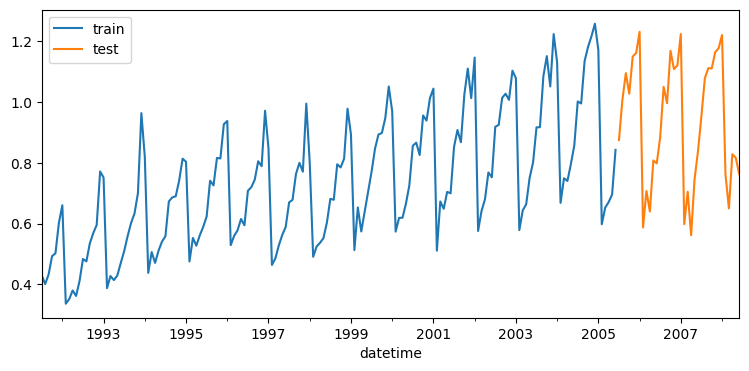

In [2]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Split train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

## Train forecaster

In [3]:
# Custom function to create predictors
# ==============================================================================
def create_predictors(y):
    """
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    """

    lags = y[-1:-11:-1]
    mean = np.mean(y[-20:])
    predictors = np.hstack([lags, mean])

    return predictors

In [4]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                 regressor      = RandomForestRegressor(random_state=123),
                 fun_predictors = create_predictors,
                 window_size    = 20
             )

forecaster.fit(y=data_train)
forecaster

ForecasterAutoregCustom 
Regressor: RandomForestRegressor(random_state=123) 
Predictors created with function: create_predictors 
Window size: 20 
Transformer for y: None 
Transformer for exog: None 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-09-24 08:26:57 
Last fit date: 2022-09-24 08:26:57 
Skforecast version: 0.5.0 
Python version: 3.9.13 

## Prediction

In [5]:
# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps)
predictions.head(3)

2005-07-01    0.926598
2005-08-01    0.948202
2005-09-01    1.020947
Freq: MS, Name: pred, dtype: float64

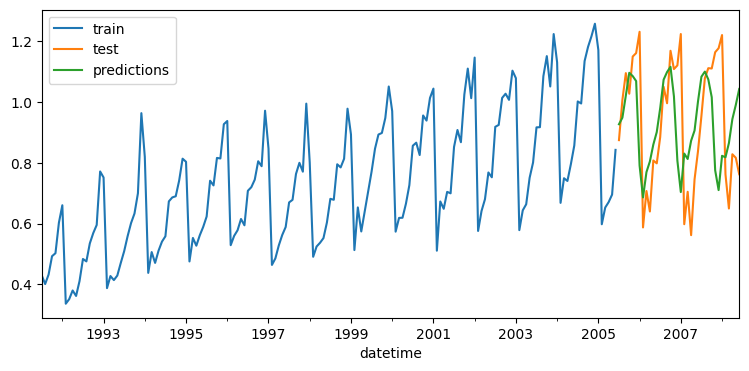

In [6]:
# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [7]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.04487765885818191


## Feature importance

In [8]:
forecaster.get_feature_importance()

,feature,importance
0,custom_predictor_0,0.539720
1,custom_predictor_1,0.119097
2,custom_predictor_2,0.046404
3,custom_predictor_3,0.024165
4,custom_predictor_4,0.030567
5,custom_predictor_5,0.015139
6,custom_predictor_6,0.042883
7,custom_predictor_7,0.012742
8,custom_predictor_8,0.018938
9,custom_predictor_9,0.108639


## Extract training matrix

In [9]:
X, y = forecaster.create_train_X_y(data_train)
X.head()

,custom_predictor_0,custom_predictor_1,custom_predictor_2,custom_predictor_3,custom_predictor_4,custom_predictor_5,custom_predictor_6,custom_predictor_7,custom_predictor_8,custom_predictor_9,custom_predictor_10
datetime,,,,,,,,,,,
1993-03-01,0.387554,0.751503,0.771258,0.595223,0.568606,0.534761,0.475463,0.483389,0.410534,0.361801,0.496401
1993-04-01,0.427283,0.387554,0.751503,0.771258,0.595223,0.568606,0.534761,0.475463,0.483389,0.410534,0.496275
1993-05-01,0.413890,0.427283,0.387554,0.751503,0.771258,0.595223,0.568606,0.534761,0.475463,0.483389,0.496924
1993-06-01,0.428859,0.413890,0.427283,0.387554,0.751503,0.771258,0.595223,0.568606,0.534761,0.475463,0.496759
1993-07-01,0.470126,0.428859,0.413890,0.427283,0.387554,0.751503,0.771258,0.595223,0.568606,0.534761,0.495638


In [10]:
y.head()

datetime
1993-03-01    0.427283
1993-04-01    0.413890
1993-05-01    0.428859
1993-06-01    0.470126
1993-07-01    0.509210
Freq: MS, Name: y, dtype: float64

In [11]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>